In [1]:
from pathlib import Path
import numpy as np
import yaml 
from scripts.eval import plot_agent_eval
from memsearch.metrics import AvgAccuracy, AvgAUC, DiscSumOfRewards

BASE_LOG_DIR = Path("logs/test_logs/experiment_results")
TASK_NAME = "predict_location"
SAVE_DIR = Path("images/test")
EXP_TO_EVAL = Path("/home/tanmayx/SVL/memory_object_search/logs/test_logs/experiment_results/iclr_pl_l_d_d_l_n_n")

/home/tanmayx/anaconda3/envs/mos/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def is_agent_name(test_str):
    ignore_keys = ['experiment=iclr', 'image', 'hydra']
    for key in ignore_keys:
        if key in test_str:
            return False
    return True

exp_name = EXP_TO_EVAL.stem
agents = [dirname for dirname in EXP_TO_EVAL.iterdir() if dirname.is_dir() and is_agent_name(str(dirname))]
all_agent_names = [agent_path.stem for agent_path in agents]
print("found {} agents".format(len(agents)))
print(all_agent_names)

found 8 agents
['memorization', 'random', 'upper_bound', 'psg_mlp', 'psg_gcn', 'counts', 'psg_heat', 'priors']


In [3]:
save_dir = str(SAVE_DIR / exp_name / TASK_NAME)
Path(save_dir).mkdir(parents=True, exist_ok=True)
metrics = [
        AvgAccuracy('%s_%s_avg_ac'%(exp_name, TASK_NAME), save_dir),
        AvgAUC('%s_%s_avg_AuC'%(exp_name,TASK_NAME), save_dir),
        DiscSumOfRewards('%s_%s_avg_DSoR'%(exp_name, TASK_NAME), save_dir)
]

# Read the task config file to determine num smoothing steps
def find_num_smoothing_steps():
        task_cfg_path = "configs/task/{}.yaml".format(TASK_NAME)
        task_cfg_fp = open(task_cfg_path, "r")
        task_cfg = yaml.safe_load(task_cfg_fp)
        return task_cfg['task']['num_smoothing_steps']

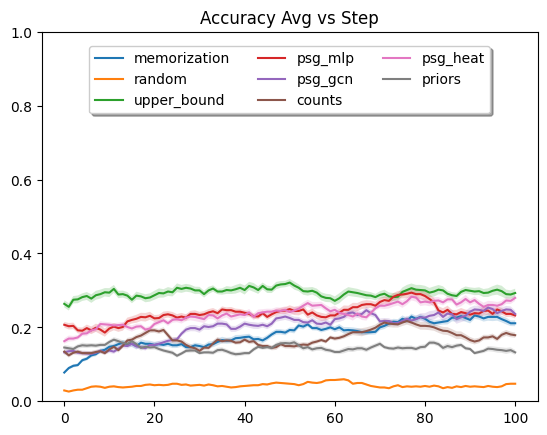

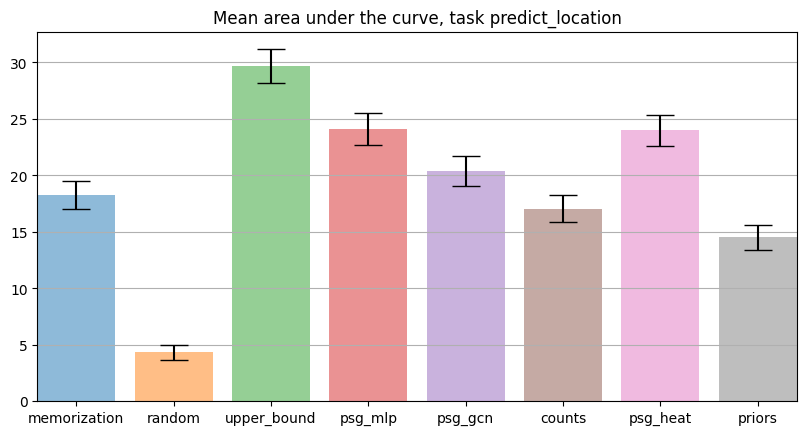

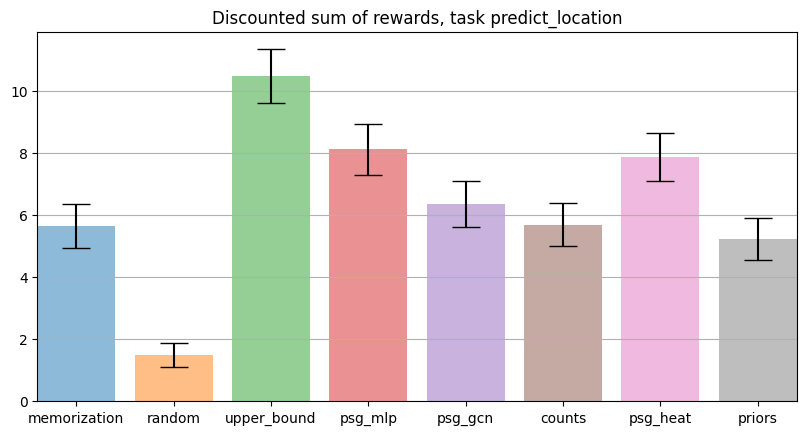

In [4]:
num_smoothing_steps = find_num_smoothing_steps()
for i, agent_csv_path in enumerate(agents):
    csv_path = agent_csv_path / "eval.csv"
    agent_name = agent_csv_path.stem
    f = open(str(csv_path.resolve()), "r")
    score_vecs = [np.array(l.split(','), dtype=np.float32) for l in f.readlines()]
    num_scenes, num_steps = len(score_vecs), score_vecs[0].shape[0]
    save_figs = (i == len(agents) - 1)
    plot_agent_eval(num_steps, score_vecs, agent_name, i, metrics,
                        smoothing_kernel_size=num_smoothing_steps, task=TASK_NAME, 
                        show_fig=False, save_fig=save_figs, x_labels=all_agent_names)